In [1]:
import xml.etree.ElementTree as ET
from pathlib import Path
import json
import os
from PIL import Image
import numpy as np

from matplotlib import pyplot as plt
import cv2
from IPython.display import clear_output

%config Completer.use_jedi = False



Bad key "text.kerning_factor" on line 4 in
/home/addfor/anaconda3/envs/smart_tray/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
CLASSES_AS_RECIPE = ["multi", "Recipe", "recipe"]

CLASSES_AS_FOOD = ["PRIMO","SECONDO","CONTORNO","INSALATA","PIZZA","PIATTO.UNICO","YOGURT","MINESTRA","DESSERT","PROD.FORNO","BIBITE","FRUTTA", \
        "bread", "yogurt", "fruit", "Food", "Bread", "Fruit", "Yogurt", "other", "yougurt", "single_food", "multi_food", "bulk_food", "drinks", "salad", "mini_salad"]

DATASETS_LIST = [
    "run_3_revisited_5may2021",
    "Sodexo_revisited_8jun",
    "Test_Empoli_01_06_2021",
    "Test_Empoli_08_06_2021",
    "Test_Empoli_09_06_2021",
    "Test_Empoli_26_05_2021",
    "Test_Empoli_27_05_2021",
    "Test_Empoli_28_05_2021",
    "Test_Empoli_29_04_2021",
    "Test_Empoli_30_04_2021",
    "Test_Empoli_31_05_2021",
    "Test_Empoli_from_10_06_2021_to_30_06_2021",
    "UNIMIB_revisited_7giu2021"
]

# OUTPUT_PATH = Path('/home/addfor/projects/smart_tray/mAP/input')
BASE_PATH = Path('/mnt/data/smarttray/dataset_05jul2021_av3b/')

In [6]:
def read_xml(xml_file: str):                                                                                                                                                                                                                                      
    tree = ET.parse(xml_file)                                                                                                                                                                                                                                                   
    root = tree.getroot()                                                                                                                                                                                                                                                       
    list_with_all_boxes = []                                                                                                                                                                                                                                                    
    for boxes in root.iter('object'): 
        class_name = boxes.find("name").text                                                                                                                                                                                                                                          
        ymin, xmin, ymax, xmax = None, None, None, None                                                                                                                                                                                                                         
        ymin = int(float(boxes.find("bndbox/ymin").text))                                                                                                                                                                                                                       
        xmin = int(float(boxes.find("bndbox/xmin").text))                                                                                                                                                                                                                       
        ymax = int(float(boxes.find("bndbox/ymax").text))                                                                                                                                                                                                                       
        xmax = int(float(boxes.find("bndbox/xmax").text))   
        list_with_all_boxes.append([class_name, xmin, ymin, xmax, ymax])
        
    return list_with_all_boxes

In [7]:
def draw_bbs(img, bbs, color):
    height, width, _ = img.shape
    for ymin, xmin, ymax, xmax in bbs:
        cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, 10)

In [10]:
d = {'images':[], 'annotations':[], 'categories':[{'supercategory':'food', 'id':int(1), 'name':'food'}]}
category_id = 1
multi_piatto_dim = 700
        
img_id, bb_id = 0, 0
for ds in DATASETS_LIST:
    print(f'Doing dataset {ds}\n')
    path = BASE_PATH/ds/'val'/'images'
    if not os.path.exists(path): continue

    for IMG_path in path.iterdir():
        if IMG_path.is_dir(): continue
#         IMG = np.asarray(Image.open(IMG_path))
        
        xml_path = IMG_path.parent.parent/'annotations'/(IMG_path.stem + '.xml')
        anns = read_xml(xml_path)
        for class_name, X1, Y1, X2, Y2 in anns:
            
            if class_name not in CLASSES_AS_FOOD: continue
                
            crop_width, crop_height = X2 - X1, Y2 - Y1
            if (crop_width > multi_piatto_dim) and (crop_height > multi_piatto_dim): 
                img_path = IMG_path.parent/IMG_path.stem
#                 if not img_path.exists(): os.mkdir(img_path)
#                 img = IMG[Y1:Y2,X1:X2]
#                 Image.fromarray(img).save(str(img_path/f'{img_id}.jpg'))

                has_recipes = False
                for class_name, x1, y1, x2, y2 in anns:
                    if class_name not in CLASSES_AS_RECIPE: continue          
                    if X1 < (x1+x2)/2 < X2 and Y1 < (y1+y2)/2 < Y2:
                        has_recipes = True
                        x1, y1, x2, y2 = max(0, x1-X1), max(0, y1-Y1), min(crop_width-1, x2-X1), min(crop_height-1, y2-Y1)
                         
                        d["annotations"].append({"iscrowd"    : 0,
                                                 "image_id"   : img_id,
                                                 "bbox"       : [x1, y1, x2-x1, y2-y1],
                                                 "area"       : 100,
                                                 "category_id": category_id,
                                                 "id"         : bb_id
                                                })
                        bb_id +=  1
                        
                if not has_recipes:
                    d["annotations"].append({"iscrowd"    : 0,
                                             "image_id"   : img_id,
                                             "area"       : 100,
                                             "bbox"       : [0, 0, crop_width-1, crop_height-1],
                                             "category_id": category_id,
                                             "id"         : bb_id
                                            })
                    bb_id +=  1
                    
                d['images'].append({"file_name"     : f'{img_id}.jpg',
                                    "id"            : img_id,
                                    "path_from_base": str(Path(ds)/'val/images'/IMG_path.stem/f'{img_id}.jpg'),
                                    "dataset"       : ds,
                                    "original_img"  : IMG_path.stem
                                   })
                
#                 bbs = []
#                 for ann in d['annotations']:
#                     if ann['image_id'] == img_id:
#                         x1,y1,w,h = ann['bbox']
#                         bbs.append([y1,x1,y1+h,x1+w]) 
#                 print(bbs, img.shape, str(Path(ds)/'val/images'/IMG_path.stem/f'{img_id}.jpg'))
#                 draw_bbs(img, bbs, [0,0,255])
#                 fig, ax = plt.subplots(figsize=(7,6))
#                 ax.imshow(img)
#                 plt.show()
#                 x = input('Press enter to continue')
#                 if x=='c': raise Exception()
#                 clear_output()                        

                img_id += 1
    
            
    
with open(BASE_PATH/'COCO_format_results(Adrian)'/'det2'/'det2val.json', 'w+') as f:
    json.dump(d, f, indent=4)      

Doing dataset run_3_revisited_5may2021

Doing dataset Sodexo_revisited_8jun

Doing dataset Test_Empoli_01_06_2021

Doing dataset Test_Empoli_08_06_2021

Doing dataset Test_Empoli_09_06_2021

Doing dataset Test_Empoli_26_05_2021

Doing dataset Test_Empoli_27_05_2021

Doing dataset Test_Empoli_28_05_2021

Doing dataset Test_Empoli_29_04_2021

Doing dataset Test_Empoli_30_04_2021

Doing dataset Test_Empoli_31_05_2021

Doing dataset Test_Empoli_from_10_06_2021_to_30_06_2021

Doing dataset UNIMIB_revisited_7giu2021



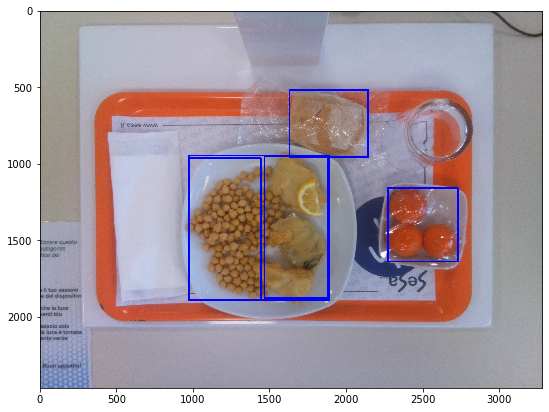

In [11]:
img = np.asarray(Image.open(BASE_PATH/'run_3_revisited_5may2021/val/images/1606824140596_11.jpg'))
anns = read_xml(BASE_PATH/'run_3_revisited_5may2021/val/annotations/1606824140596_11.xml')
bbs = [[y1,x1,y2,x2] for _,x1,y1,x2,y2 in anns]
draw_bbs(img, bbs, [0,0,255])
fig, ax = plt.subplots(figsize=(9,7))
ax.imshow(img)